### Protein Grouping based on AlphaDIA output

Start from psm.tsv output & implement protein grouping:

In [594]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Use the index of psm_table as peptide IDs for easier lookup; otherwise, the unique identifier for a precursor is the precursor_idx. Generate a dataframe `protein_table` with a `proteins` and  `peptides` column, where the latter contains sets of all peptides belonging to a certain protein. Generate a lookup list containing all peptide indices, and a boolean state vector of the same length to indicate whether this peptide has been taken by a protein. 

- 1.: Identify proteotypic precursors --> this has an issue for now, proteins apparently only contains protein ambiguity groups (e.g. isoforms)
- 2.: Merge all proteins in `protein_table` if their peptides are identical.
- 3.: Merge all proteins in `protein_table` into ambiguity groups if their peptides are subsets of each other
- 4.: Use greedy set cover to assign peptides to proteins by the razor principle & maximum parsimony

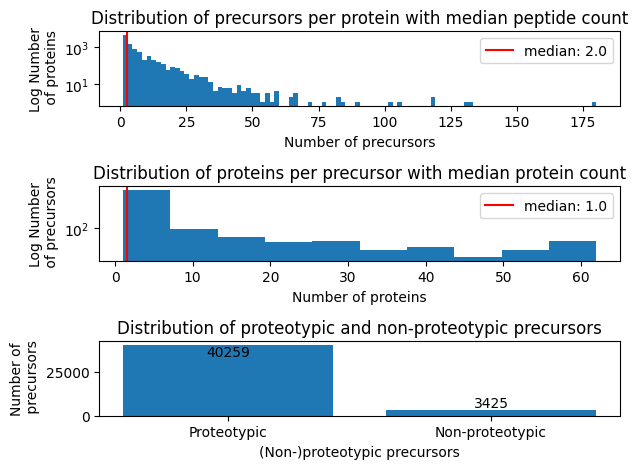

In [595]:
#retrieve psm.tsv output table
precursor_table = pd.read_csv("./../../../../data/alphadia_example_output/psm.tsv", sep = "\t")

#Generate dataframe where each row is a protein and the peptides are in a set
protein_table = precursor_table.groupby("proteins").apply(lambda x : set(x.index)).reset_index(name = "peptides")
protein_table.sort_values(by = "peptides", key = lambda x : x.str.len(), ascending = False, inplace = True)

#Convert csv protein names to set
precursor_table["proteins_set"] = precursor_table.proteins.apply(lambda x : set(x.split(";")))
precursor_table.sort_values(by = "proteins_set", key = lambda x : x.str.len(), ascending = False, inplace = True)

#Add proteotypicity column
precursor_table["proteotypic"] = precursor_table.proteins_set.apply(lambda x : len(x) == 1)

#visualize distribution of peptide counts per protein and proteins per peptide
fig, ax = plt.subplots(3, 1)
ax[0].hist(protein_table.peptides.str.len(), bins = 100, log = True)
ax[0].set_xlabel("Number of precursors")
ax[0].set_ylabel("Log Number\n of proteins")
ax[0].axvline(protein_table.peptides.str.len().median() + 0.5, color = "red", label = f"median: {protein_table.peptides.str.len().median()}")
ax[0].set_title("Distribution of precursors per protein with median peptide count")
ax[0].legend()
ax[1].hist(precursor_table.proteins_set.str.len(), bins = 10, log = True)
ax[1].set_xlabel("Number of proteins")
ax[1].set_ylabel("Log Number\n of precursors")
ax[1].axvline(precursor_table.proteins_set.str.len().median() + 0.5, color = "red", label = f"median: {precursor_table.proteins_set.str.len().median()}")
ax[1].set_title("Distribution of proteins per precursor with median protein count")
ax[1].legend()
ax[2].bar(["Proteotypic", "Non-proteotypic"], [precursor_table.proteotypic.sum(), np.abs((~precursor_table.proteotypic).sum())], log = False)
ax[2].set_title("Distribution of proteotypic and non-proteotypic precursors")
#label bars with counts
for i, v in enumerate([precursor_table.proteotypic.sum(), np.abs((~precursor_table.proteotypic).sum())]):
    alignment = ["top" if v > precursor_table.proteotypic.sum()/2 else "bottom"][0]
    ax[2].text(i, v, str(v), ha = "center", va = alignment)
ax[2].set_xlabel("(Non-)proteotypic precursors")
ax[2].set_ylabel("Number of\n precursors")
fig.tight_layout()

plt.show()

In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def split_targets_decoys(
        precursor_table: pd.DataFrame,
):
    return (
        precursor_table[precursor_table["_decoy"] == 0],
        precursor_table[precursor_table["_decoy"] == 1]
    )

def extract_precursor_columns(
        precursor_table: pd.DataFrame,
        precursor_idx_column_name: str = "precursor_idx",
        proteins_column_name: str = "proteins",
):
    #extract columns from dataframe into lists:
    precursor_idx = precursor_table[precursor_idx_column_name].values
    proteins_set = [set(s.split(";")) for s in precursor_table[proteins_column_name].values]

    return proteins_set, precursor_idx

def collapse_identical_precursors(
        proteins_set: list,
        precursor_idx: np.array,
):
    """Utility for collapsing precursor rows: 
    If n runs are processed, the same precursor_idx occurs n times. The purpose of this function is to collapse these rows into one"""

    collapsed_precursor_idx = []
    collapsed_proteins_set = []
    #track progress with tqdm
    for prec, prot in tqdm(zip(precursor_idx, proteins_set), total = len(precursor_idx)):
        if prec not in collapsed_precursor_idx:
            collapsed_precursor_idx.append(prec)
            collapsed_proteins_set.append(prot)
        else:
            pass
    return collapsed_proteins_set, collapsed_precursor_idx

def get_protein_longtable(
        proteins_set: list,
        precursor_idx: np.array,
):
    """Transform precursor table into protein table.
    Example: transforming a table like this:
    
    | precursor_id | proteins_set |
    |--------------|--------------|
    | 1            | A;B          |
    | 2            | A;C          |
    | 3            | D            |

    Into a table like this:

    | protein_id | peptides |
    |------------|----------|
    | A          | 1        |
    | A          | 2        |
    | B          | 1        |
    | C          | 2        |
    | D          | 3        |

    Args:
        precursor_idx: array of precursor indices
        proteins_set: list of sets of proteins per precursor index
    """

    protein = []
    peptide = []
    for idx, prot in tqdm(zip(precursor_idx, proteins_set), total = len(precursor_idx)):
        for p in prot:
            protein.append(p)
            peptide.append(idx)

    return protein, peptide

def collapse_protein_longtable(
        protein: list, 
        peptide: list,
):
    """Transform protein -  peptide longtable by collapsing peptides of identical proteins into sets.
    Example: transforming a table like this:

    | protein_id | peptides |
    |------------|----------|
    | A          | 1        |
    | A          | 2        |
    | B          | 1        |
    | C          | 2        |
    | D          | 3        |

    Into a table like this:

    | protein_id | peptides |
    |------------|----------|
    | A          | 1;2      |
    | B          | 1        |
    | C          | 2        |
    | D          | 3        |

    Args:
        protein: list of protein IDs
        peptide: list of peptide precursor indices
    """

    protein_ids = []
    peptide_sets = []
    for prot, pep in tqdm(zip(protein, peptide), total = len(protein)):
        if prot not in protein_ids:
            protein_ids.append(prot)
            peptide_sets.append(set([pep]))
        else:
            peptide_sets[protein_ids.index(prot)].add(pep)

    return protein_ids, peptide_sets

def group_proteins(
        protein_ids: list,
        peptide_sets: list,
):
    """Group proteins based on peptide sets.
    Example: transforming a table like this:

    | protein_id | peptides |
    |------------|----------|
    | A          | {1;2}    |
    | B          | {1}      |
    | C          | {2}      |
    | D          | {2;3}    |

    Into a table like this:

    | protein_ids | peptides           |
    |-------------|--------------------|
    | [A,B,C]     | [{1;2},{1},{2}]    |
    | [C,D]       | [{2};{2;3}]        |

    RAZOR PEPTIDES: Peptide 2 is a razor peptide and also provides evidence for protein C. Therefore peptide 2 as well as protein C are assigned to all groups that claim peptide 2. 
    This has to be resolved with maximum parsimony later. Resolving razors later necessitates that we keep track of which protein "contributed" which peptide set.

    Args:
        protein_dict: A dictionary with a unique protein_id column and a peptide_set column
    """

    global_protein_group = []
    global_peptide_sets = []

    #iterate over all proteins, then for each protein find its non-self subset proteins and combine into one group 
    #these groups are inflated: proteins match each other and create completely identical groups --> these can be merged!

    for i, (query_id, query_set) in enumerate(tqdm(zip(protein_ids, peptide_sets), total = len(protein_ids))):
        local_protein_ids = [query_id]
        local_peptide_sets = [query_set]
        for n, (subject_id, subject_set) in enumerate(zip(protein_ids, peptide_sets)):
            if n == i:
                continue
            else:
                if subject_set.issubset(query_set):
                    local_protein_ids.append(subject_id)
                    local_peptide_sets.append(subject_set)

        global_protein_group.append(local_protein_ids)
        global_peptide_sets.append(local_peptide_sets)

    #merge completely identical groups, going by comparing their protein list in global_protein_group
    keep_status = np.ones(len(global_protein_group), dtype = bool)
    for i, query_protein_list in enumerate(tqdm(global_protein_group, total = len(global_protein_group))):
        for n, subject_protein_list in enumerate(global_protein_group):
            if n == i:
                continue
            else:
                if sorted(query_protein_list) == sorted(subject_protein_list):
                    if keep_status[i] == True:
                        keep_status[n] = False

    global_protein_group = [x for i, x in enumerate(global_protein_group) if keep_status[i] == True]
    global_peptide_sets = [x for i, x in enumerate(global_peptide_sets) if keep_status[i] == True]

    return(global_protein_group, global_peptide_sets)

def apply_strict_parsimony(
        protein_groups: list,
        peptide_sets: list,
):
    """Strict parsimony to decide which peptides and proteins to keep for a protein group:
    
    Args:
        protein_groups: list containing N groups, i.e. lists of Q protein ID strings
        peptide_sets: list containing N peptide sets, i.e. lists of Q of peptide indices
        strict_parsimony: If True, every peptide is used exactly once and razor peptides are assigned to the largest group. Greedy Set cover is used for grouping.
    """

    #helper function to compare to lists of sets as if they were sets and update the associated protein list when set lengths go to zero
    def compare_set_lists(query_set_list, subject_peptide_set_list, subject_protein_list):
        """Utility for comparing one query set to a list of suject sets.
        
        Args:
            query_set: set of elements to check against subject sets
            subject_peptide_set_list: list of sets
        
        Returns:
            _subject_peptide_set_list: list of sets with all elements from query set removed
            merge_indices: list of indices of sets in _subject_peptide_set_list that went empty
        """
        drop_indices = []
        _subject_peptide_set_list = subject_peptide_set_list.copy()
        for query_set in query_set_list:
            for n, _subject_set in enumerate(_subject_peptide_set_list):
                _subject_set = _subject_set.difference(query_set)
                if len(_subject_set) == 0:
                    drop_indices.append(n)
                    #explicitly set to empty set for now
                    _subject_peptide_set_list[n] = set()
                else:
                    _subject_peptide_set_list[n] = _subject_set

        #update subject protein list accordingly
        #_subject_protein_list = [None if i in drop_indices else x for i, x in enumerate(subject_protein_list)]

        return _subject_peptide_set_list, subject_protein_list, drop_indices

    #record all peptides from all sets
    available_peptides = set().union(*[set().union(*x) for x in peptide_sets]) #U
    covered_peptides = set() #C

    final_protein_groups = []
    final_peptide_sets = []

    #greedy set cover: number of iterations equals number of protein groups in input
    #the maximum number of iterations is the number of protein groups in the input. If all available peptides are covered before that, the loop breaks
    for n in range(len(protein_groups)):

        #check if all peptides are covered # while U is nonempty, in this case while U is not equivalent to C
        if len(available_peptides.difference(covered_peptides)) == 0:
            print(f"all peptides covered by {n} protein groups")
            break

        else:
            #compute unique peptides and their count for each protein group's peptide sets
            unique_peptide_sets = [set().union(*x) for x in peptide_sets]
            unique_peptide_set_len = [len(x) for x in unique_peptide_sets]

            #order protein groups and peptide sets by their count of unique peptides
            sort_idx = np.argsort(unique_peptide_set_len)[::-1]
            protein_groups = [protein_groups[i] for i in sort_idx]
            peptide_sets = [peptide_sets[i] for i in sort_idx]

            #remove the top peptide set list and protein group from peptide_sets and protein_groups, respectively --> this group is the query and is added to the final output
            #corresponds to select set s(i) that covers the most elements of U
            query_peptide_set_list = peptide_sets.pop(0)
            query_protein_list = protein_groups.pop(0)
            
            final_peptide_sets.append(query_peptide_set_list)
            final_protein_groups.append(query_protein_list)

            #update covered peptides # corresponds to add s(i) to C
            covered_peptides = covered_peptides.union(*query_peptide_set_list)

            #iterate over remaining protein groups:
            #delete the query peptides from each peptide set. If a set becomes empty, remove it and its associated protein in the group
            for i in range(len(peptide_sets)):
                #reassign peptide sets and protein groups after comparison to query
                peptide_sets[i], protein_groups[i], _ = compare_set_lists(query_peptide_set_list, peptide_sets[i], protein_groups[i])

    return {
        "protein_groups": final_protein_groups, 
        "peptide_sets": final_peptide_sets
    }

def protein_grouping(
        precursor_table: pd.DataFrame,
):
    targets, decoys = split_targets_decoys(precursor_table)
    proteins, peptides = extract_precursor_columns(targets)
    proteins, peptides = collapse_identical_precursors(proteins, peptides)
    proteins, peptides = get_protein_longtable(proteins, peptides)
    proteins, peptides = collapse_protein_longtable(proteins, peptides)
    display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))
    proteins, peptides = group_proteins(proteins, peptides)
    grouped_dict = apply_strict_parsimony(proteins, peptides)
    return grouped_dict

In [22]:
#sample data:
import pandas as pd
precursor_idx = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]
proba = [x / (x + 10) for x in precursor_idx]

df = pd.DataFrame({
    "precursor_idx": precursor_idx,
    "proteins": ['P1;P2;P3;P4', 'P1;P2;P3;P4', 'P1;P2', 'P1;P2', 'P4', 'P4', 'P4;P5', 'P4;P5', 'P6', 'P6'],
    "_decoy": [0,0,0,0,0,0,0,0,1,1],
    "proba": proba
})

print("Input Precursor Table from two runs")
display(df)

print("subset targets:")
targets, decoys = split_targets_decoys(df)
display(targets)

print("add protein sets:")
proteins, peptides = extract_precursor_columns(targets)
display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))

print("collapse identical precursors which could originate from multiple runs:")
proteins, peptides = collapse_identical_precursors(proteins, peptides)
display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))

print("elongate to get protein table:")
proteins, peptides = get_protein_longtable(proteins, peptides)
display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))

print("collapse protein longtable and get peptide sets. Notice how P1 and P2 have the exact same peptide set")
proteins, peptides = collapse_protein_longtable(proteins, peptides)
display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))

print("apply protein grouping in a greedy manner: proteins and peptides can belong to multiple groups")
proteins, peptides = group_proteins(proteins, peptides)
display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))

print("apply strict parsimony for grouping")
ds = apply_strict_parsimony(proteins, peptides)
display(pd.DataFrame(ds))

Input Precursor Table from two runs


,precursor_idx,proteins,_decoy,proba
0,0,P1;P2;P3;P4,0,0.000000
1,0,P1;P2;P3;P4,0,0.000000
2,1,P1;P2,0,0.090909
3,1,P1;P2,0,0.090909
4,2,P4,0,0.166667
5,2,P4,0,0.166667
6,3,P4;P5,0,0.230769
7,3,P4;P5,0,0.230769
8,4,P6,1,0.285714
9,4,P6,1,0.285714


subset targets:


,precursor_idx,proteins,_decoy,proba
0,0,P1;P2;P3;P4,0,0.000000
1,0,P1;P2;P3;P4,0,0.000000
2,1,P1;P2,0,0.090909
3,1,P1;P2,0,0.090909
4,2,P4,0,0.166667
5,2,P4,0,0.166667
6,3,P4;P5,0,0.230769
7,3,P4;P5,0,0.230769


add protein sets:


,proteins,peptides
0,"{P1, P4, P3, P2}",0
1,"{P1, P4, P3, P2}",0
2,"{P1, P2}",1
3,"{P1, P2}",1
4,{P4},2
5,{P4},2
6,"{P5, P4}",3
7,"{P5, P4}",3


collapse identical precursors which could originate from multiple runs:


100%|██████████| 8/8 [00:00<00:00, 241398.79it/s]


,proteins,peptides
0,"{P1, P4, P3, P2}",0
1,"{P1, P2}",1
2,{P4},2
3,"{P5, P4}",3


elongate to get protein table:


100%|██████████| 4/4 [00:00<00:00, 161319.38it/s]


,proteins,peptides
0,P1,0
1,P4,0
2,P3,0
3,P2,0
4,P1,1
5,P2,1
6,P4,2
7,P5,3
8,P4,3


collapse protein longtable and get peptide sets. Notice how P1 and P2 have the exact same peptide set


100%|██████████| 9/9 [00:00<00:00, 140329.87it/s]


,proteins,peptides
0,P1,"{0, 1}"
1,P4,"{0, 2, 3}"
2,P3,{0}
3,P2,"{0, 1}"
4,P5,{3}


apply protein grouping in a greedy manner: proteins and peptides can belong to multiple groups


100%|██████████| 5/5 [00:00<00:00, 109226.67it/s]


,proteins,peptides
0,"[P1, P3, P2]","[{0, 1}, {0}, {0, 1}]"
1,"[P4, P3, P5]","[{0, 2, 3}, {0}, {3}]"
2,[P3],[{0}]
3,[P5],[{3}]


apply strict parsimony for grouping
all peptides covered by 2 protein groups


,protein_groups,peptide_sets
0,"[P4, P3, P5]","[{0, 2, 3}, {0}, {3}]"
1,"[P1, P3, P2]","[{1}, {}, {1}]"


In [81]:
#sample data:
import pandas as pd
precursor_table = pd.read_csv("./../../../../data/alphadia_example_output/psm.tsv", sep = "\t")
example_data = precursor_table.iloc[0:15]

print("subset targets:")
targets, decoys = split_targets_decoys(precursor_table)
display(targets.head())

print("convert to dictionary and add protein sets:")
proteins, peptides = extract_precursor_columns(targets)
display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))

print("collapse identical precursors which could originate from multiple runs:")
proteins, peptides = collapse_identical_precursors(proteins, peptides)
display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))

print("elongate to get protein table:")
proteins, peptides = get_protein_longtable(proteins, peptides)
display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))

print("collapse protein longtable and get peptide sets. Notice how P1 and P2 have the exact same peptide set")
proteins, peptides = collapse_protein_longtable(proteins, peptides)
display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))

print("apply protein grouping in a greedy manner: proteins and peptides can belong to multiple groups")
proteins, peptides = group_proteins(proteins, peptides)
display(pd.DataFrame({"proteins": proteins, "peptides": peptides}))

print("apply strict parsimony for grouping")
ds = apply_strict_parsimony(proteins, peptides)
display(pd.DataFrame(ds))

subset targets:


,base_width_mobility,base_width_rt,rt_observed,mobility_observed,mono_ms1_intensity,top_ms1_intensity,sum_ms1_intensity,weighted_ms1_intensity,weighted_mass_deviation,weighted_mass_error,...,rt_library,i_0,flat_frag_start_idx,channel,i_2,mz_library,_decoy,proba,qval,run
0,0.0,61.264650,4150.9365,0.000001,168609580.0,168609580.0,414403260.0,128811016.0,-0.059417,0.059417,...,3805.9788,0.346696,355530,0,0.194793,946.43380,0.0,0.000028,0.0,HF_20210523_M300-Y700_DIA_3
1,0.0,39.634766,3776.8835,0.000001,27051602.0,26593468.0,70354530.0,20971468.0,-0.171322,0.171322,...,3442.0386,0.309100,498472,0,0.210362,1094.04240,0.0,0.000030,0.0,HF_20210523_M300-Y700_DIA_3
2,0.0,36.285156,4728.6430,0.000001,37786816.0,37786816.0,91618260.0,28982200.0,-0.038115,0.038115,...,4282.2124,0.363294,470025,0,0.188118,900.42770,0.0,0.000031,0.0,HF_20210523_M300-Y700_DIA_3
3,0.0,61.782715,5049.4670,0.000001,152851000.0,171884340.0,429470700.0,126024584.0,-0.080193,0.080193,...,4492.2950,0.301911,339007,0,0.213075,1018.02515,0.0,0.000033,0.0,HF_20210523_M300-Y700_DIA_3
4,0.0,40.335450,3715.7993,0.000001,52148544.0,52148544.0,135551440.0,40438244.0,-0.192274,0.192274,...,3427.3513,0.335526,278590,0,0.200084,931.41960,0.0,0.000049,0.0,HF_20210523_M300-Y700_DIA_3


convert to dictionary and add protein sets:


,proteins,peptides
0,{P16521},124703
1,{P38011},175743
2,{P33331},165493
3,{P14540},118869
4,{P05759},97538
...,...,...
43247,{P47068},210459
43248,{Q04178},268216
43249,"{P62830, P49690, F4J3P1, P0CX41, P0CX42}",108991
43250,{Q9Z0S1},681036


collapse identical precursors which could originate from multiple runs:


100%|██████████| 43252/43252 [00:02<00:00, 20589.55it/s]


,proteins,peptides
0,124703,{P16521}
1,175743,{P38011}
2,165493,{P33331}
3,118869,{P14540}
4,97538,{P05759}
...,...,...
8308,181923,{P38695}
8309,691287,{Q9ZUC2}
8310,97445,"{A0A1P8ASC2, P05755, F4HYG9, O13516}"
8311,408956,"{Q8CJH3, Q9QY40}"


elongate to get protein table:


100%|██████████| 8313/8313 [00:00<00:00, 2988279.84it/s]


,proteins,peptides
0,P16521,124703
1,P38011,175743
2,P33331,165493
3,P14540,118869
4,P05759,97538
...,...,...
12412,P62830,108991
12413,P49690,108991
12414,F4J3P1,108991
12415,P0CX41,108991


collapse protein longtable and get peptide sets. Notice how P1 and P2 have the exact same peptide set


100%|██████████| 12417/12417 [00:00<00:00, 18057.86it/s]


,proteins,peptides
0,P16521,"{124553, 124703}"
1,P38011,{175743}
2,P33331,{165493}
3,P14540,{118869}
4,P05759,"{97513, 97521, 97538, 97517}"
...,...,...
8617,P42844,{202435}
8618,P47095,{210930}
8619,Q9ZUC2,{691287}
8620,A0A1P8ASC2,{97445}


apply protein grouping in a greedy manner: proteins and peptides can belong to multiple groups


100%|██████████| 8622/8622 [00:17<00:00, 500.82it/s]


,proteins,peptides
0,"[P16521, P53978]","[{124553, 124703}, {124553}]"
1,[P38011],[{175743}]
2,[P33331],[{165493}]
3,[P14540],[{118869}]
4,"[P05759, P0CH09, P0CH08, P0CG63]","[{97513, 97521, 97538, 97517}, {97513, 97521, ..."
...,...,...
7696,[Q810J8],[{379969}]
7697,[P42844],[{202435}]
7698,[P47095],[{210930}]
7699,[Q9ZUC2],[{691287}]


apply strict parsimony for grouping
{262145, 524290, 245762, 278532, 311303, 491528, 245770, 524299, 98322, 163860, 229397, 393236, 507928, 196633, 294941, 213023, 376863, 278561, 229410, 196647, 49192, 147497, 163890, 262196, 229430, 180281, 196665, 294974, 524353, 213063, 49225, 294988, 196685, 360525, 245839, 262227, 278612, 163925, 196702, 376927, 360543, 229473, 344160, 295013, 262246, 311400, 98410, 147566, 344174, 245872, 229490, 131190, 196727, 163960, 262263, 278653, 360577, 376962, 295043, 163971, 131209, 196745, 295051, 295052, 524428, 147597, 295059, 327829, 245909, 213143, 344220, 360605, 376988, 229535, 114846, 196769, 393378, 295068, 98468, 376997, 376998, 196775, 311456, 344233, 98473, 32944, 245936, 295089, 213175, 131256, 196796, 49341, 229564, 278717, 164033, 295109, 196807, 311496, 262345, 49355, 98508, 164046, 180431, 491727, 196819, 131284, 671957, 377051, 180444, 344283, 606430, 622818, 49379, 49381, 491751, 213227, 327916, 114927, 278768, 524531, 278772, 196852,

,protein_groups,peptide_sets
0,[P68372],"[{521922, 521986, 522084, 245698, 245670, 5219..."
1,[P10592],"[{111105, 111362, 111139, 111236, 111170, 1111..."
2,"[P68369, P05214, Q3UX10]","[{245504, 245473, 315496, 245642, 245482, 2456..."
3,"[P0C2I5, P0C2J1, P0C2I3, P0C2I9, Q04711, O1352...","[{266088, 266056, 266059, 266124, 266061, 2661..."
4,"[B1AWN6, Q9JJV9, Q9ER60, Q6QIY3, F4KHP4, A0A1P...","[{7138, 7109, 7177, 7180, 7101, 7121, 7185, 71..."
...,...,...
7062,[P29453],[{151591}]
7063,[Q9QX47],[{619223}]
7064,[P28028],[{148827}]
7065,[P53011],[{223373}]


### Outline for Protein Grouping:

#### 1. Starting point: Long Table of protein - peptide relationship
This table contains one protein - peptide relationship per row. 
#### 2. Collapse long table into peptide sets
All peptides belonging to one protein ID are summarized in a set. After this step, protein IDs are unique but peptide sets can be identical
#### 3. Protein Grouping in greedy manner
Proteins with identical peptide sets are combined into one protein group. If the peptides of protein A are a subset of protein B's peptides, the two form a group. of note, proteins can be claimed by multiple groups at this point
#### 4. Apply maximum parsimony
This algorithm ensures that every peptide is only claimed by one protein group. Disputed peptides that are claimed by two or more groups go to the group with most unique peptides. If removing razor peptide(s) from a given group removes all evidence for a certain protein, the protein is dropped from that group.

# Check against old implementation

In [65]:
import pandas as pd
precursor_idx = [0, 1, 2, 3, 4]
proba = [x / (x + 10) for x in precursor_idx]

sample_precursor_table = pd.DataFrame({
    "precursor_idx": precursor_idx,
    "proteins": ['P1;P2;P3;P4', 'P1;P2', 'P4', 'P4;P5', 'P6'],
    "_decoy": [0,0,0,0,1],
    "proba": proba
})

print("Input Data:")
display(sample_precursor_table)

print("Pandas based grouping:")
new_protein_table, _ = strict_protein_grouping(sample_precursor_table)
display(new_protein_table)

print("List based grouping:")
new_protein_table = protein_grouping(sample_precursor_table)
display(pd.DataFrame(new_protein_table))


Input Data:


,precursor_idx,proteins,_decoy,proba
0,0,P1;P2;P3;P4,0,0.000000
1,1,P1;P2,0,0.090909
2,2,P4,0,0.166667
3,3,P4;P5,0,0.230769
4,4,P6,1,0.285714


Pandas based grouping:


,protein,peptides,peptide_set_string
0,P1;P2,"{0, 1}",0;1
1,P3,{0},0
2,P4,"{0, 2, 3}",0;2;3
3,P5,{3},3


Protein grouping: 100%|██████████| 4/4 [00:00<00:00, 1443.57it/s]

P1;P2
{0, 1}
[0 1]
P4
{2, 3}
[2 3]
P4
set()
[]
P4
set()
[]


,protein,peptides
0,P1;P2,"[0, 1]"
1,P4,[]


List based grouping:


100%|██████████| 9/9 [00:00<00:00, 172368.66it/s]


,proteins,peptides
0,P2,"{0, 1}"
1,P4,"{0, 2, 3}"
2,P1,"{0, 1}"
3,P3,{0}
4,P5,{3}


100%|██████████| 4/4 [00:00<00:00, 30504.03it/s]


,protein_groups,peptide_sets
0,"[P4, P3, P5]","[{0, 2, 3}, {0}, {3}]"
1,"[P2, P1, None]","[{1}, {1}, {}]"
2,[None],[{}]
3,[None],[{}]


# First Pandas Implementation

In [64]:
#bug in main loop, do not use
def strict_protein_grouping(
    precursor_table: pd.DataFrame,
    graphical_output: bool = False
    ):

    """Function to perform parsimonious protein grouping
    Args:
        precursor_table: long table where rows are precursors with continuous indices and a "proteins" column contains semicolon-separated strings of protein names
    """

    import pandas as pd
    import numpy as np
    from tqdm import tqdm
    if graphical_output:
        raise NotImplementedError("Graphical output not implemented yet")

    #exclude decoys
    precursor_table = precursor_table[precursor_table._decoy == 0]
    precursor_table = precursor_table.reset_index(drop = True)

    #Record proteotypic precursors
    precursor_table["protein_set"] = precursor_table.proteins.apply(lambda x : set(x.split(";")))
    precursor_table = precursor_table.sort_values(by = "protein_set", key = lambda x : x.str.len(), ascending = False)
    
    precursor_table["proteotypic"] = precursor_table.protein_set.apply(lambda x : len(x) == 1)
    
    #compile set of all peptide indices & create lookup array for peptide indices
    peptide_indices = set(precursor_table.index)
    peptide_lookup = np.ones(len(peptide_indices), dtype = bool)

    #protein dataframe: repeated rows for each protein that belongs to a peptide
    protein_table = {"protein": [], "peptide": []}
    for i, row in precursor_table.iterrows():
        peptide_index = i
        proteins = row["protein_set"]
        for protein in proteins:
            protein_table["peptide"].append(peptide_index)
            protein_table["protein"].append(protein)
    protein_table = pd.DataFrame(protein_table).groupby("protein").apply(lambda x : set(x.peptide)).reset_index(name = "peptides")

    #GROUPING: summarize proteins with identical peptide sets into protein groups and remove duplicated rows --> now, each row is a protein group
    protein_table["peptide_set_string"] = protein_table.peptides.apply(lambda x : ";".join([str(i) for i in sorted(list(x))]))
    protein_table["protein"] = protein_table.groupby("peptide_set_string")["protein"].transform(lambda x : ";".join(x))
    protein_table = protein_table.drop_duplicates(subset = "protein").reset_index(drop = True)
    display(protein_table)

    #Iterate over protein_table and remove peptides from lookup array as they are assigned to a new group
    new_protein_table = {}
    with tqdm(total = protein_table.shape[0]) as pbar:
        pbar.set_description("Protein grouping")
        for i in range(protein_table.shape[0]):    
            #check lookup array if current query peptides are taken & update lookup array & save new group
            query_protein = protein_table.iloc[0]["protein"]
            query_peptides = np.array(list(protein_table.iloc[0]["peptides"]), dtype = np.int64)

            keep_peptides = query_peptides[peptide_lookup[query_peptides]]
            peptide_lookup[keep_peptides] = False
            new_protein_table[query_protein] = keep_peptides

            #costly updating part: update each set in protein_table[peptides] to remove peptide indices that are in keep_set & resort
            protein_table.peptides = protein_table.peptides.apply(lambda x : set(x).difference(set(keep_peptides)))
            protein_table = protein_table.sort_values(by = "peptides", key = lambda x : x.str.len(), ascending = False)

            #update progress bar
            pbar.update(1)
    
    #convert new_protein_table to dataframe
    new_protein_table = pd.DataFrame({
        "protein": list(new_protein_table.keys()),
        "peptides": list(new_protein_table.values())
    }).sort_values(by = "peptides", key = lambda x : x.str.len(), ascending = False)
    
    return new_protein_table, protein_table


### Sample run with AlphaDIA output: 

This is only for benchmarking, since this precursor table already contains pre-filtered groups.

In [774]:
precursor_table = pd.read_csv("./../../../../data/alphadia_example_output/psm.tsv", sep = "\t")
example_data = precursor_table.iloc[0:25]
display(example_data)

,base_width_mobility,base_width_rt,rt_observed,mobility_observed,mono_ms1_intensity,top_ms1_intensity,sum_ms1_intensity,weighted_ms1_intensity,weighted_mass_deviation,weighted_mass_error,...,rt_library,i_0,flat_frag_start_idx,channel,i_2,mz_library,_decoy,proba,qval,run
0,0.0,61.264650,4150.9365,0.000001,168609580.0,168609580.0,414403260.0,128811016.0,-0.059417,0.059417,...,3805.9788,0.346696,355530,0,0.194793,946.43380,0.0,0.000028,0.0,HF_20210523_M300-Y700_DIA_3
1,0.0,39.634766,3776.8835,0.000001,27051602.0,26593468.0,70354530.0,20971468.0,-0.171322,0.171322,...,3442.0386,0.309100,498472,0,0.210362,1094.04240,0.0,0.000030,0.0,HF_20210523_M300-Y700_DIA_3
2,0.0,36.285156,4728.6430,0.000001,37786816.0,37786816.0,91618260.0,28982200.0,-0.038115,0.038115,...,4282.2124,0.363294,470025,0,0.188118,900.42770,0.0,0.000031,0.0,HF_20210523_M300-Y700_DIA_3
3,0.0,61.782715,5049.4670,0.000001,152851000.0,171884340.0,429470700.0,126024584.0,-0.080193,0.080193,...,4492.2950,0.301911,339007,0,0.213075,1018.02515,0.0,0.000033,0.0,HF_20210523_M300-Y700_DIA_3
4,0.0,40.335450,3715.7993,0.000001,52148544.0,52148544.0,135551440.0,40438244.0,-0.192274,0.192274,...,3427.3513,0.335526,278590,0,0.200084,931.41960,0.0,0.000049,0.0,HF_20210523_M300-Y700_DIA_3
5,0.0,31.887695,4398.2950,0.000001,20202464.0,20202464.0,49092316.0,15942830.0,-0.080891,0.080891,...,3961.4795,0.383799,774797,0,0.177739,886.92550,0.0,0.000051,0.0,HF_20210523_M300-Y700_DIA_3
6,0.0,41.511230,3386.5290,0.000001,14635544.0,18360156.0,47378496.0,13298930.0,-0.251007,0.251007,...,3158.9795,0.265214,781079,0,0.228616,811.70703,0.0,0.000052,0.0,HF_20210523_M300-Y700_DIA_3
7,0.0,40.752075,1814.5244,0.000001,37633770.0,37633770.0,80839620.0,28574280.0,-0.338338,0.338338,...,1938.5044,0.431434,1013328,0,0.157065,810.37900,0.0,0.000059,0.0,HF_20210523_M300-Y700_DIA_3
8,0.0,41.626220,3067.2158,0.000001,5558951.0,7919580.5,19642362.0,5452008.0,-0.738537,0.738537,...,2971.9880,0.258391,944427,0,0.229986,851.38430,0.0,0.000061,0.0,HF_20210523_M300-Y700_DIA_3
9,0.0,58.977050,6021.6577,0.000001,26805754.0,26805754.0,62411176.0,20217636.0,0.057561,0.057561,...,5312.5444,0.368763,1234653,0,0.184048,591.31240,0.0,0.000068,0.0,HF_20210523_M300-Y700_DIA_3


### Minimal Example

In [605]:
#sample data
psm_test = pd.DataFrame({
    "proteins": ["P1","P1","P1;P2","P1;P2","P2"],
    "decoy" : [0,0,0,0,0]
})

#test
display(psm_test)
out, old = strict_protein_grouping(psm_test)
display(old)
display(out)

,proteins,decoy
0,P1,0
1,P1,0
2,P1;P2,0
3,P1;P2,0
4,P2,0


Protein grouping: 100%|██████████| 2/2 [00:00<00:00, 1563.58it/s]


,protein,peptides,peptide_set_string
1,P2,{},2;3;4
0,P1,{},0;1;2;3


,protein,peptides
0,P1,"[0, 1, 2, 3]"
1,P2,[4]


# Appendix

### Evaluate Protein Grouping from AlphaPept

In [276]:
Import alphawrap to quickly set up and run alphapept analyses on sample data.
from alphawrap.data_processing.alphawrap import runAlphaPept
from alphawrap.data_processing.utils import modifySettingsFile
import os

input_directory = "./../../testdata/"
modifySettingsFile(
    input_directory,
    "test_settings.yaml",
    "test_settings.yaml",
    input_directory,
    ["20200911_EXPL0_IgPa_6min_DDA_2.raw"],
    ["irtfusion.fasta"]
)
runAlphaPept(
    settings_directory = "./../../testdata/",
    settings_modified_name = "test_settings.yaml",
    results_directory = input_directory,
    results_prefix = "test_"
)

SyntaxError: invalid syntax (3703317738.py, line 1)

In [261]:
for i, v in enumerate([[1,2,3], [3,4,5]]):
    print(i, v)

0 [1, 2, 3]
1 [3, 4, 5]
